# Terrestrial Planets
## (Without Tides)

### Parameter Interpolation

If parameters are changing significantly on dynamical timescales (e.g. mass transfer at pericenter on very eccentric orbits) you need a specialized numerical scheme to do that accurately.
However, there are many astrophysical settings where parameters change very slowly compared to all the dynamical timescales in the problem.
As long as this is the case and the changes are adiabatic, you can modify these parameters between calls to `sim.integrate` very flexibly and without loss of accuracy. 

In order to provide a machine-independent way to interpolate parameters at arbitrary times, which can be shared between the C and Python versions of the code, we have implemented an interpolator object. 
For example, say you want to interpolate stellar evolution data.
We show below how you can use the `Interpolator` structure to spline a discrete set of time-parameter values.

We begin by reading in mass and radius data of our Sun, starting roughly 5 million years before the tip of its red-giant branch (RGB), and separating them into time and value arrays. 
You can populate these arrays however you want, but we load two text files (one for stellar mass, the other for stellar radius), where the first column gives the time (e.g., the Sun's age), and the second column gives the corresponding value (mass or radius).

All values need to be in simulation units. If you're using AU, then your stellar radii should also be in AU.

In [1]:
import numpy as np

data = np.loadtxt('mesa2txt/m.txt') # return (N, 2) array
mtimes = data[:, 0]                 # return only 1st col
masses = data[:, 1]                 # return only 2nd col

data = np.loadtxt('mesa2txt/r.txt')
rtimes = data[:, 0]
Rsuns = data[:, 1]                  # data in Rsun units

radii = np.zeros(Rsuns.size)        # convert Rsun to AU
for i, r in enumerate(Rsuns):
    radii[i] = r * 0.00465047       # 215 Rsun ~ 1 AU

Next we set up the Sun and all four terrestrial planets.

In [2]:
import rebound
import reboundx

M0 = 0.8868357536545315 # initial mass of star
names = ['Sun', 'Mercury', 'Venus', 'Earth', 'Mars']
symbols = ['☉', '☿', '♀︎', '⊕', '♂︎']

def makesim():
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')
    sim.add(m=M0, hash=names[0])
    sim.add(m=0.166e-6, a=0.39, hash=names[1])
    sim.add(m=2.45e-6, a=0.723, hash=names[2])
    sim.add(m=3.e-6, a=1., hash=names[3])
    sim.add(m=0.323e-6, a=1.524, hash=names[4])
    sim.integrator = 'whfast'
    sim.dt = 0.1*sim.particles[1].P
    sim.move_to_com()
    return sim

Now we can create an `Interpolator` object for each parameter set and pass the corresponding arrays as arguments.

In [3]:
sim = makesim()
rebx = reboundx.Extras(sim)
starmass = reboundx.Interpolator(rebx, mtimes, masses, 'spline')
starradius = reboundx.Interpolator(rebx, rtimes, radii, 'spline')

# update Sun's mass and radius accordingly
ps = sim.particles
T0 = 12388.5e6 # Sun's age ~ 5 Myr pre-TRGB (sim start)
ps[0].m = starmass.interpolate(rebx, t=T0)
ps[0].r = starradius.interpolate(rebx, t=T0)
sim.move_to_com()

In [4]:
print('M0 =', starmass.interpolate(rebx, t=T0), 'Msun')
print('R0 =', starradius.interpolate(rebx, t=T0), 'Rsun')

M0 = 0.8868357536545315 Msun
R0 = 0.3343621584715825 Rsun


Finally, we integrate for 5 Myr, updating the central body's mass and radius interpolated at the time between outputs. We then plot the resulting system:

In [5]:
%%time
Nout = 1000
mass = np.zeros(Nout)
radius = np.zeros(Nout)
a = np.zeros([Nout, sim.N])
ts = np.linspace(0., 5.e6, Nout)
cp = 1     # index of closest survivng planet
emass = 0. # mass of engulfed planets

for i, time in enumerate(ts):
    sim.integrate(time)
    d = ps[0] - ps[cp]             # componentwise difference to nearest planet
    r = np.sqrt(d.x**2 + d.y**2 + d.z**2)
    
    if r <= ps[0].r:               # nearest planet engulfed
        emass += ps[cp].m          # add engulfed planet mass
        ps[cp].m = 0               # zero planet mass and move to COM
        ps[cp].x, ps[cp].y, ps[cp].z = 0, 0, 0
        cp += 1                    # next closest surviving planet
        sim.dt = 0.1*ps[cp].P      # adjust timestep accordingly
        
    # evolve Sun and recenter to COM
    ps[0].m = starmass.interpolate(rebx, t=T0+sim.t) + emass
    ps[0].r = starradius.interpolate(rebx, t=T0+sim.t)
    sim.move_to_com()
    
    # record values for post-sim plots
    mass[i] = sim.particles[0].m
    radius[i] = sim.particles[0].r
    for j in range(1, sim.N):
        a[i, j] = ps[j].a

/home/stanley/miniconda3/envs/rebx/lib/python3.7/site-packages/rebound/simulation.py:675: RuntimeWarning: WHFast convergence issue. Timestep is larger than at least one orbital period.
  warnings.warn(msg[1:], RuntimeWarning)


CPU times: user 3min 58s, sys: 1min 9s, total: 5min 7s
Wall time: 5min 9s


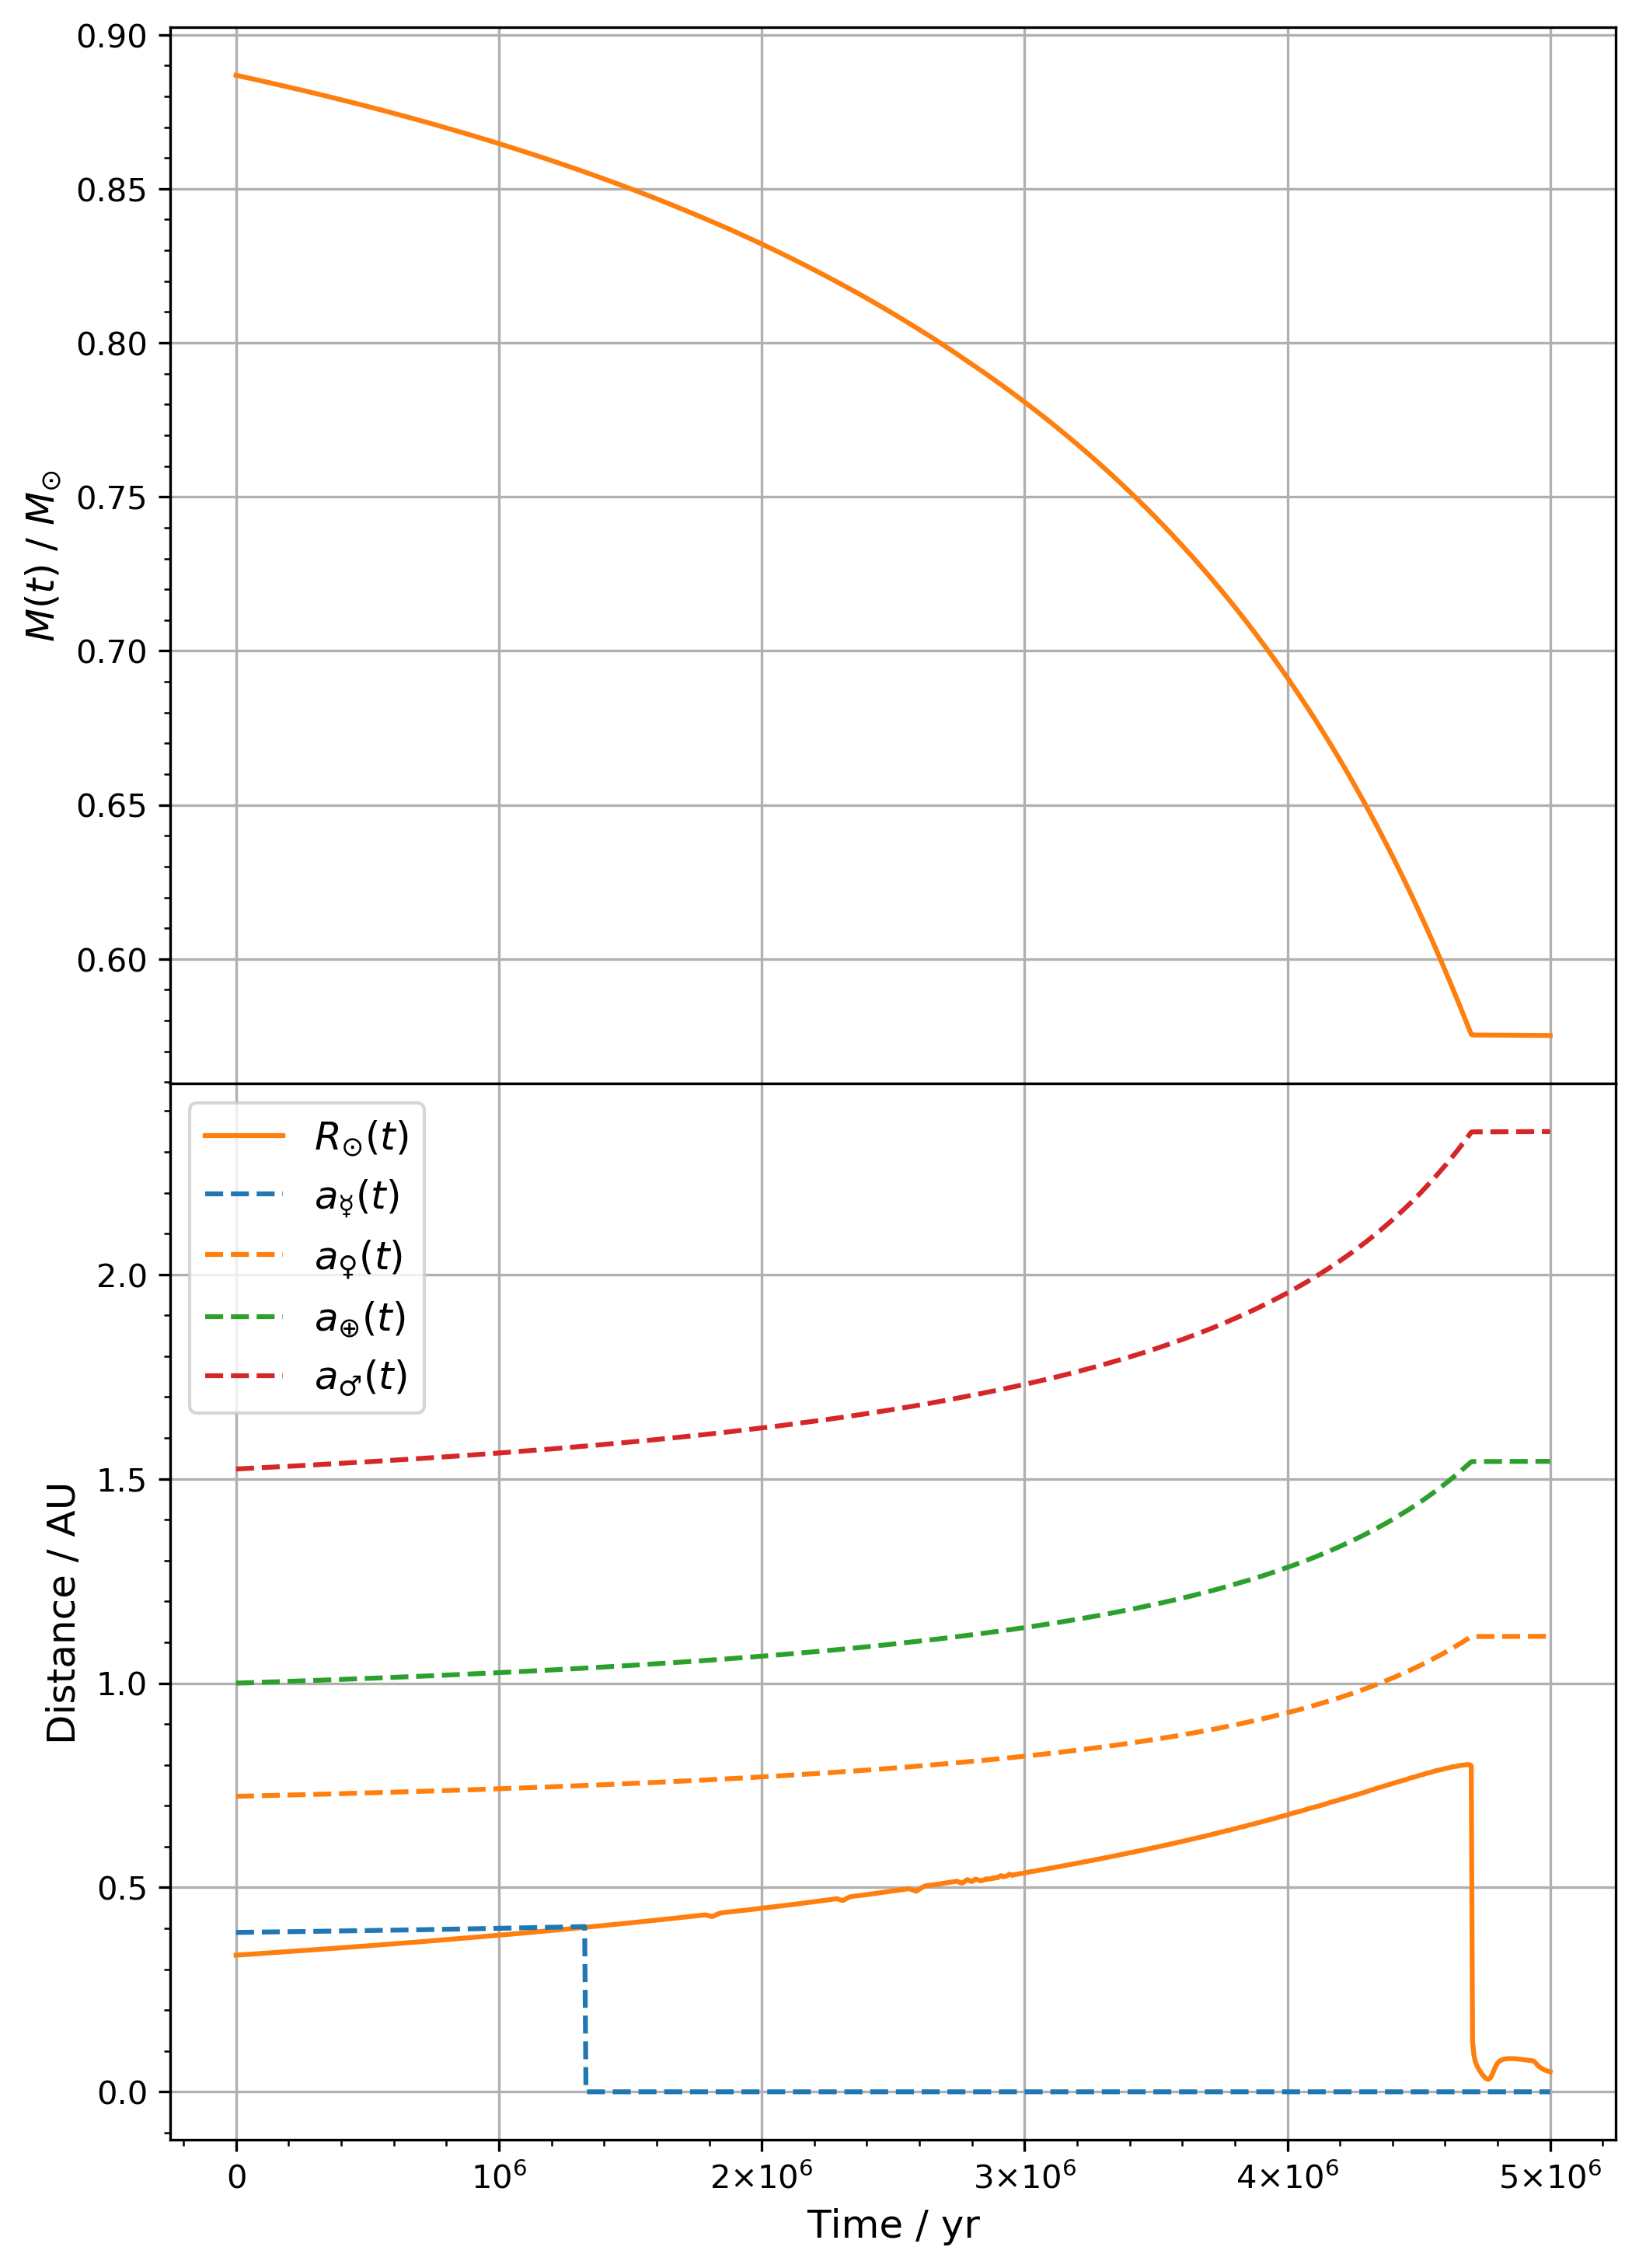

In [6]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8, 12), dpi=300)
fig.subplots_adjust(hspace=0)

ax1.set_ylabel("$M(t)$ / $M_{\odot}$", fontsize='large')
ax1.yaxis.set_minor_locator(mticker.AutoMinorLocator())
ax1.plot(ts,mass, color='tab:orange')
ax1.grid()

ax2.set_xlabel('Time / yr', fontsize='large')
ax2.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
ax2.xaxis.set_minor_locator(mticker.AutoMinorLocator())
ax2.set_ylabel('Distance / AU', fontsize='large')
ax2.yaxis.set_minor_locator(mticker.AutoMinorLocator())
ax2.plot(ts,radius, color='tab:orange', label='$R_{\odot}(t)$')
for i in range(1, sim.N):
    label = '$a_{%s}(t)$'%(symbols[i])
    ax2.plot(ts,a[:, i], '--', label=label)
ax2.legend(fontsize='large', loc='best')
ax2.grid()

plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(g))
plt.savefig('plots/terrestrial.png')

### NOTE
The `%%timeit` cell below failed to reset the simulation after each run, hence the longer average wall time.

In [5]:
%%timeit
Nout = 1000
mass = np.zeros(Nout)
radius = np.zeros(Nout)
a = np.zeros([Nout, sim.N])
ts = np.linspace(0., 5.e6, Nout)
cp = 1                             # index of closest survivng planet
emass = 0.                         # mass of engulfed planets

for i, time in enumerate(ts):
    sim.integrate(time)
    d = ps[0] - ps[cp]             # componentwise difference to nearest planet
    r = np.sqrt(d.x**2 + d.y**2 + d.z**2)
    
    if r <= ps[0].r:               # nearest planet engulfed
        emass += ps[cp].m          # add engulfed planet mass
        ps[cp].m = 0               # zero planet mass and move to COM
        ps[cp].x, ps[cp].y, ps[cp].z = 0, 0, 0
        cp += 1                    # next closest surviving planet
        sim.dt = 0.1*ps[cp].P      # adjust timestep accordingly
        
    # evolve Sun and recenter to COM
    ps[0].m = starmass.interpolate(rebx, t=T0+sim.t) + emass
    ps[0].r = starradius.interpolate(rebx, t=T0+sim.t)
    sim.move_to_com()
    
    # record values for post-sim plots
    mass[i] = sim.particles[0].m
    radius[i] = sim.particles[0].r
    for j in range(1, sim.N):
        a[i, j] = ps[j].a

/home/stanley/miniconda3/envs/rebx/lib/python3.7/site-packages/rebound/simulation.py:675: RuntimeWarning: WHFast convergence issue. Timestep is larger than at least one orbital period.
  warnings.warn(msg[1:], RuntimeWarning)


10min 8s ± 2min 40s per loop (mean ± std. dev. of 7 runs, 1 loop each)
